# Clasificacion de fallas electricas

El objetivo de este trabajo es poder predecir si hubo una falla electrica a partir de los valores de corriente y voltage registrados en cada fase, se analizaran los siguientes metodos de clasificacion para poder ver cual es la mas adecuada para este problema:
- Regresion logistica
- KNN (K Vecinos Mas Cercanos por sus siglas en ingles)
- SVM (Maquina de Soporte Vectorial por sus siglas en ingles)
- Naive Bayes
- Arbol de decision
- Random Forest

Este trabajo se baso en el paper [Deteccion y clasificacion de fallas (electricas) utilizando Machine Learning](https://www.ijraset.com/research-paper/fault-detection-and-classification-using-ml) [1] realizado por Suresh Kumar, Abhinav Varma, Devika Rani, Nishanth del Chaitanya Bharathi Institute of Technology.

Los investigadores recrearon un sistema electrico utilizando MATLAB para poder registrar los datos, realizar estas simulaciones es muy bueno para poder aislar mejor el sistema a analizar, sin que este sea afectados por variables externas.

A diferencia del paper original donde se intento predecir individualmente cada tipo de falla, este trabajo solo se limitara a predecir si hubo o no una falla electrica.

Los datos utilizados pueden encontrarse en [kaggle - electrical fault detection and classification](https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification) [2].

## Dependencias

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, precision_score, accuracy_score,
    recall_score, f1_score, roc_auc_score, classification_report,
    )
import random # para tener colores random
import warnings
warnings.filterwarnings("ignore")

# Revisando el dataset

El dataset contiene las siguientes columnas:
- `G`: puede ser 0 o 1, donde 1 indica que hay una falla en la conexion a tierra.
- `C`: puede ser 0 o 1, donde 1 indica que hay una falla en la fase C.
- `B`: puede ser 0 o 1, donde 1 indica que hay una falla en la fase B.
- `A`: puede ser 0 o 1, donde 1 indica que hay una falla en la fase A.
- `Ia`: corriente en la fase A.
- `Ib`: corriente en la fase B.
- `Ic`: corriente en la fase C.
- `Va`: voltaje en la fase A.
- `Vb`: voltaje en la fase B.
- `Vc`: voltaje en la fase C.

In [45]:
dataset = pd.read_csv('./content/fallas-electricas.csv')
dataset.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


## Primer procesado y Analisis exploratorio

Es indiferente si el fallo se produjo entre las fases AB o si ocurrio en la fases BC, por lo cual se agregara una nueva columna con las siguientes categorias para clasificar la falla segun la cantidad de fases y si fallo a tierra.
- `sin falla`: no hubo ninguna falla en el sistema.
- `falla LG`: falla entre una fase y tierra.
- `falla LL`: falla entre 2 fases.
- `falla LLG`: falla entre 2 fases y tierra
- `falla LLL`: falla entre 3 fases.
- `falla LLLG`: falla entre 3 fases y tierra.

In [47]:
def clasificar_falla(x):
    resultado = ""
    for col in ['C', 'B', 'A']:
        if x[col]:
            resultado += 'L'
    if x['G']:
        resultado += 'G'
    return 'falla ' + resultado if resultado else 'sin falla'
#
dataset['tipo de fallo'] = dataset.apply(clasificar_falla, axis=1)
dataset.sample(5)

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,tipo de fallo
623,1,0,0,1,857.965800,61.275709,-8.827499,-0.137591,-0.084605,0.222196,falla LG
5451,1,1,1,1,613.833712,76.447205,10.814940,0.148612,-0.456765,0.308153,falla LLLG
5150,1,1,1,1,-626.956750,852.423744,-225.469258,0.012464,0.028848,-0.041312,falla LLLG
5846,0,0,0,0,-70.918957,54.605095,12.842840,-0.002780,-0.508988,0.511768,sin falla
4275,0,1,1,1,785.351196,-741.329752,-42.030561,0.001272,-0.059322,0.058050,falla LLL


Procedamos a realizar un grafico de correlaciones para ver que relacion hay entre las variables de corriente y voltage para cada fase

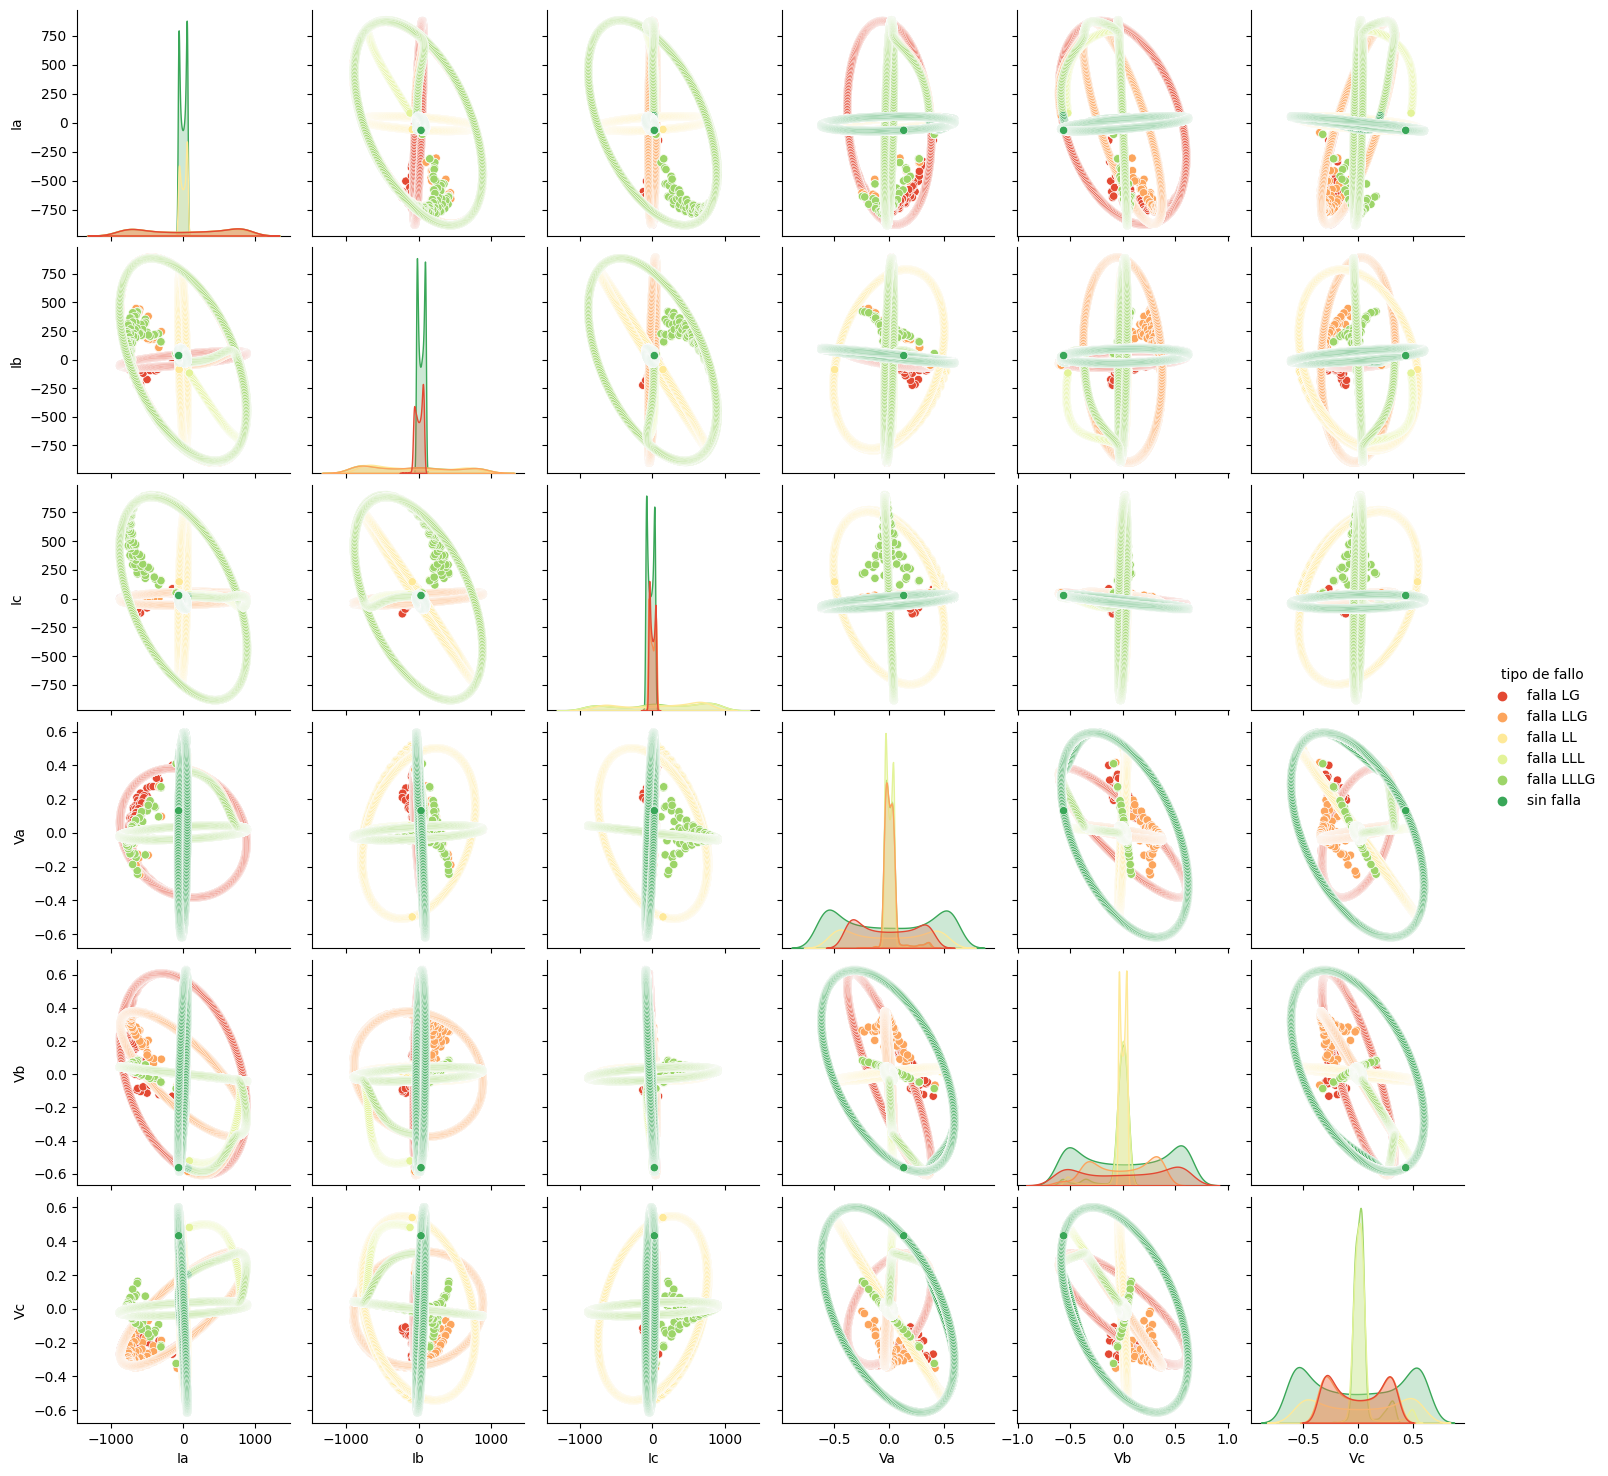

In [48]:
# Mas estilos se EDA se pueden encontrar en
# https://nlpfy.com/2018/07/21/exploratory-data-analysis-and-knn-classification-on-iris-dataset/
sns.pairplot(dataset, hue='tipo de fallo', vars=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'], palette='RdYlGn')
plt.show()

Podemos ver que cada `tipo de fallo` y `sin fallo` siguen un patron especifico, cercano a circulos o eclipses, esto nos indica dos cosas:
1. Podemos realizar una clasificacion ya que se observa correlacion entre las variables.
1. No podemos separar linealmente los datos por lo tanto el metodo de Regresion Logistica no sera el mas adecuado para este problema, aun asi vamos a utilizarlo para corroborarlo.

Tambien procederemos a crear una nueva columna `fallo` con los valores 0 para los `tipo de fallo` que sean `sin falla` y 1 para el resto. Esta columna es la principal que queremos predecir en este trabajo.

In [49]:
dataset['fallo'] = dataset['tipo de fallo'].apply(lambda x: 0 if x == 'sin falla' else 1)

Procedemos a observar cuantos registros tenemos para cada `tipo de fallo` y si es necesario balancear el dataset.

In [50]:
dataset['tipo de fallo'].value_counts()

sin falla     2365
falla LLG     1134
falla LLLG    1133
falla LG      1129
falla LLL     1096
falla LL      1004
Name: tipo de fallo, dtype: int64

Se puede observar que hay proximadamente unos 5400 registros para los fallos y solo 2365 para sin fallo, por lo cual procederemos a balancear el dataset seleccionando aleatoriamente registros de fallos hasta tener una cantidad equivalente a los registros de sin fallo.

La idea es tener una misma cantidad de registros para los tipos `sin fallo` y el resto, pero manteniendo registros de todos los tipos de fallos y asi evitar un sesgo en los modelos, por ejemplo si en el conjunto de testeo tenemos 900 fallos y 100 sin fallo, nos podria ocurrir de que el modelo nos clasifique a todos los datos como fallo y aun asi tener un 90% de precision, lo cual esta muy mal.

In [51]:
cantidad_fallos = len(dataset[dataset["fallo"] == 1])
cantidad_sin_fallos = len(dataset[dataset["fallo"] == 0])
cantidad_a_borrar = abs(cantidad_sin_fallos - cantidad_fallos)
dataset = dataset.drop(dataset[dataset['fallo'] == 1].sample(cantidad_a_borrar).index)

Veamos el resultado del balanceado:

In [52]:
dataset['tipo de fallo'].value_counts()

sin falla     2365
falla LLLG     502
falla LG       495
falla LLG      475
falla LLL      470
falla LL       423
Name: tipo de fallo, dtype: int64

Ahora si tenemos una cantidad equivalente de `sin fallo` y de fallos, sin excluir ningun tipo de fallo.

## Clasificacion con Regresion Logistica

Este metodo de clasificacion basicamente intenta predecir con reglas de la probabilidad que tan probable es que haya un fallo o no, utilizando una funcion sigmoide.

Se comienza seleccionando las columnas a utilizar, estas mismas las utilizaremos para todos los modelos de clasificacion

In [53]:
X = dataset.iloc[:, 4: 10].values
y = dataset.iloc[:, 11].values
X, y

(array([[-3.36186183e+02, -7.62832619e+01,  1.83288966e+01,
          3.12731934e-01, -1.23633156e-01, -1.89098779e-01],
        [-6.43663617e+02, -2.24159427e+02, -1.32282815e+02,
          2.09536880e-01, -9.55537510e-02, -1.13983129e-01],
        [-5.57391809e+02, -1.19468643e+02, -2.95294498e+01,
          2.10003736e-01, -7.67124530e-02, -1.33291283e-01],
        ...,
        [-6.54466976e+01,  3.64720551e+01,  2.61065537e+01,
          1.13106580e-01, -5.58210927e-01,  4.45104348e-01],
        [-6.50296327e+01,  3.54770884e+01,  2.66847311e+01,
          1.22404174e-01, -5.61094199e-01,  4.38690025e-01],
        [-6.45984013e+01,  3.44807988e+01,  2.72500649e+01,
          1.31668579e-01, -5.63834635e-01,  4.32166056e-01]]),
 array([1, 1, 1, ..., 0, 0, 0]))

Se dividen los conjuntos de entrenamiento, de prueba y se realiza el entrenamiento

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Se realiza la prediccion con regresion logistica

In [55]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Prediccion': y_pred}).sample(10)

,Actual,Prediccion
105,0,1
400,0,0
597,0,1
906,1,0
273,1,1
684,0,0
832,0,0
28,0,0
73,0,1
883,1,1


Se observa en el muestreo que algunos valores se predijeron bien y que le erro en otros, veamos la matriz de confusion para ver cuantos aciertos y errores tuvo el modelo.

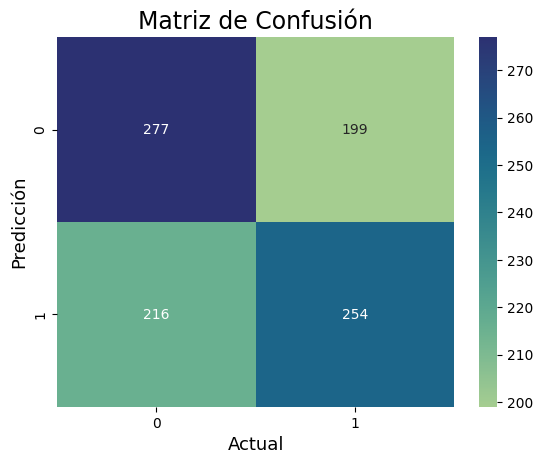

In [56]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    palletes = [
        'Blues', 'Reds', 'mako', 'crest'
        ]
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap=random.choice(palletes),
        )
    plt.ylabel('Predicción', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Matriz de Confusión', fontsize=17)
    plt.show()
#
plot_confusion_matrix(y_test, y_pred)

Podemos observar que obtuvimos 277 aciertos para clasificar el tipo `sin fallos` y 254 aciertos para los fallos, lo cual comparado con los falsos valores (de 199 y 216 respectivamente), es una prediccion media mala.

Veamos exactamente las metricas que hemos obtenido con el modelo

In [57]:
def plot_metricas(y_test, y_pred):
    print(f'Precisión del modelo: {precision_score(y_test, y_pred):.2f}')
    print(f'Exactitud del modelo: {accuracy_score(y_test, y_pred):.2f}')
    print(f'Sensibilidad del modelo: {recall_score(y_test, y_pred):.2f}')
    print(f'Puntaje F1 del modelo: {f1_score(y_test, y_pred):.2f}')
    print(f'Curva ROC - AUC del modelo: {roc_auc_score(y_test, y_pred):.2f}')
#
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.56
Exactitud del modelo: 0.56
Sensibilidad del modelo: 0.54
Puntaje F1 del modelo: 0.55
Curva ROC - AUC del modelo: 0.56


vemos una precision del 0.57, lo cual es medio malo comparandolo con el 0.50 que se obtendria si se predijera al azar.

## Clasificacion con KNN (K Vecinos Mas Cercanos) 

Basicamente este metodo de clasificacion intenta predecir si fallo o no, basandose en que tan cercanos son los datos en un espacio multidimensional.

Utilizamos los mismo X e Y que en la clasificacion anterior, volvemos a dividir los datos de entrenamiento y de test, luego entrenamos el modelo

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
#
classifier = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

Prodecemos a realizar la prediccion

In [59]:
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicción': y_pred}).sample(10)

,Actual,Predicción
252,0,0
848,0,0
859,0,0
873,1,1
383,0,0
695,1,1
515,1,1
224,1,1
109,0,0
907,0,0


Vemos en el muestro que el modelo predijo bien algunos valores, mucho mejor que en la clasificacion anterior con Regresion Lineal, veamos la matriz de confusion para ver el total de aciertos y errores.

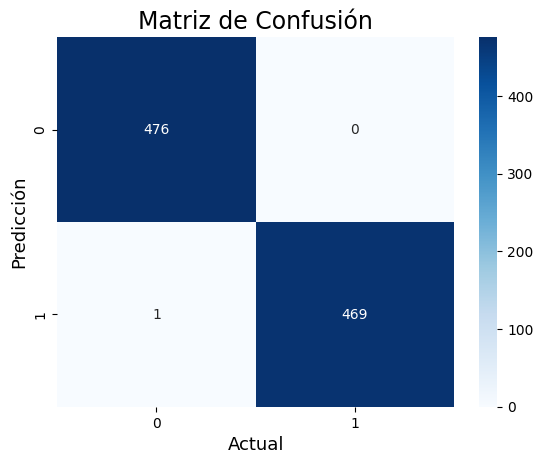

In [60]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver en la matriz de confusion que se obtuvieron 476 aciertos para predecir `sin fallo`, 470 aciertos para predecir `falla LLG` y 1 falsos positivos o negativos, lo cual hace que tenga una muy buena precision.

Veamos las metricas obtenidas con KNN:

In [61]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 1.00
Exactitud del modelo: 1.00
Sensibilidad del modelo: 1.00
Puntaje F1 del modelo: 1.00
Curva ROC - AUC del modelo: 1.00


Vemos que se obtuvo un 100% de precision, lo cual puede decirnos dos cosas, que el modelo se adapta muy bien para clasificar los errores

## Clasificacion con Maquina de Soporte Vectorial

Basicamente este metodo de clasificacion intenta predecir una categoria, separando los datos con hiperplanos, el negativo y positivo que son los mas cercanos a los datos y el hiperplano optimo que es el intermedio entre ambos.

Al igual que en las clasificaciones anteriores, se procede a dividir en conjuntos de entrenamiento y de test, luego entrenamos el modelo

Utilizaremos el Kernel RBF ya que debemos clasificar utilizando 6 dimensiones (una dimension para cada voltage y corriente en cada fase) y puede que los conjuntos no sea linealmente separable.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
#
classifier = SVC(kernel = "rbf", random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [63]:
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicción': y_pred}).sample(10)

,Actual,Predicción
538,0,0
362,0,0
815,0,0
186,1,1
856,0,0
851,0,0
731,0,0
1063,1,1
1175,0,0
1060,1,1


Nuevamente podemos ver una muy buena similitud entre los valores Actuales y los de Prediccion, procedamos a realizar una matriz de confusion para ver cuantos aciertos obtuvimos

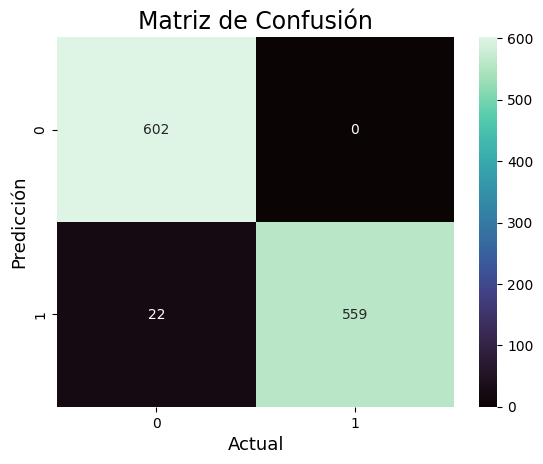

In [64]:
plot_confusion_matrix(y_test, y_pred)

Podemos observar que obtuvimos una muy buena cantidad de aciertos, comparando los verdaderos positivos y negativos con los falsos positivos y negativos, veamos las metricas que el modelo obtuvo:

In [65]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 1.00
Exactitud del modelo: 0.98
Sensibilidad del modelo: 0.96
Puntaje F1 del modelo: 0.98
Curva ROC - AUC del modelo: 0.98


Nuevamente una precision del 100% como en KNN

## Clasificacion con Naive Beyes

Basicamente este metodo de clasificacion utiliza el Teorema de Bayes, el cual intenta predecir cual es la probabilidad de que un evento ocurra comparando las caracteristicas de este evento vs la probabilidad de que ocurra un evento similar.

Al igual que las anteriores clasificaciones, se procede a dividir los conjuntos de entrenamiento y de testeo, luego procedemos a entrenarlo

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
#
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Muestreo de algunos valores de prediccion vs actuales

In [67]:
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicción': y_pred}).sample(10)

,Actual,Predicción
340,0,0
948,1,1
992,1,1
1113,0,0
121,0,0
578,0,0
270,0,0
990,0,0
109,0,0
1064,1,1


Podemos observar que hay una alta similitud entre algunos valores actuales y los predichos, veamos la matriz de confusion para tener un panorama mas claro

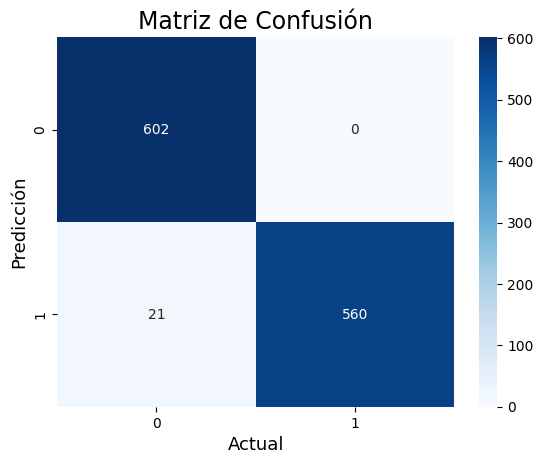

In [68]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver que en una primera impresion, que el modelo predijo muy bien los valores, veamos las metricas que obtuvo

In [69]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 1.00
Exactitud del modelo: 0.98
Sensibilidad del modelo: 0.96
Puntaje F1 del modelo: 0.98
Curva ROC - AUC del modelo: 0.98


Nuevamente obtuvimos una precision del 100%

## Clasificacion con Arboles de Decision

Este metodo de clasificacion funciona subdividiendo los datos en ramas, siguiendo como criterio el indice de Gini para realizar los cortes en las variables independientes.

Como en todos los metodos anteriores, realizamos la division de los conjuntos de entrenamiento y de testeo, luego procedemos a entrenar el modelo

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Veamos algunos valores de prediccion vs actuales

In [71]:
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicción': y_pred}).sample(10)

,Actual,Predicción
658,1,1
979,1,1
835,1,1
572,1,1
655,1,1
341,1,1
73,0,0
6,0,0
423,0,0
329,0,0


Podemos ver una alta similitud entre algunos valores actuales y predichos, realizemos una matriz de confusion para ver cuantos aciertos tuvimos en total

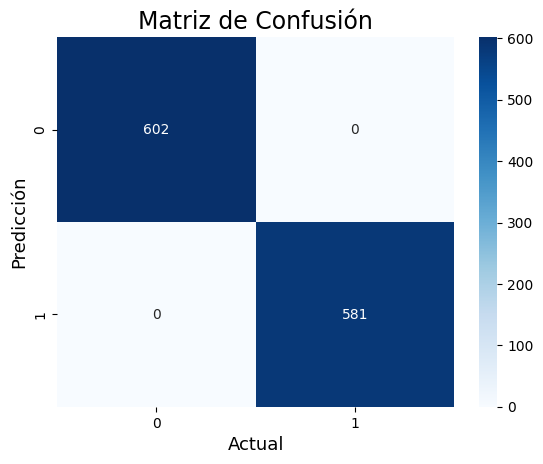

In [72]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver que obtuvimos muchos aciertos en la prediccion aunque algunos falsos negativos, veamos las metricas que obtuvimos

In [73]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 1.00
Exactitud del modelo: 1.00
Sensibilidad del modelo: 1.00
Puntaje F1 del modelo: 1.00
Curva ROC - AUC del modelo: 1.00


Podemos ver que practicamente tenemos una precision del 100% nuevamente

## Clasificacion con Random Forest

Es la version mejorada de los Arboles de Decision ya que combina multiples de estos en un mismo resultado, basicamente se seleccionan aleatoriamente los datos y se agrupan en diferentes subconjuntos, con cada uno de estos subconjuntos se construye un arbol de decision y para realizar la prediccion, se agrupan los resultados de estos arboles y se selecciona la clasificacion mas concurrida.

Al igual que con las anteriores clasificaciones, se procedera a dividir el dataset en conjuntos de entrenamiento y de testeo, luego se entrenara el modelo

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
#
classifier = RandomForestClassifier(n_estimators = 10, criterion = "entropy", random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

veamos algunos valores de prediccion vs actuales

In [75]:
y_pred = classifier.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicción': y_pred}).sample(10)

,Actual,Predicción
70,1,1
867,1,1
850,0,0
183,1,1
1169,0,0
1134,0,0
691,1,1
13,0,0
696,1,1
555,0,0


A simple vista se puede observar que son muy similares los valores actuales y los predichos, al igual que con las clasificaciones anteriores, procederemos a realizar una matriz de confusion para ver cuantos aciertos tuvimos

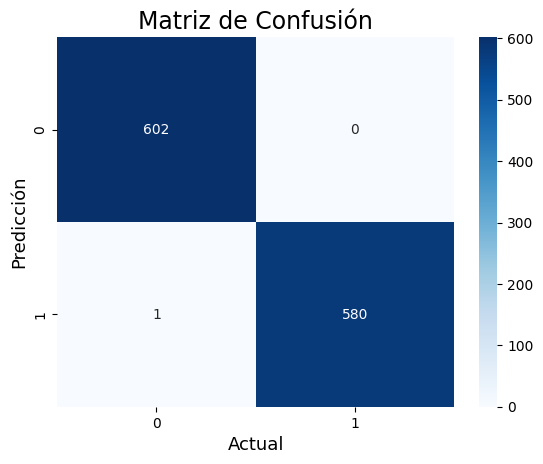

In [76]:
plot_confusion_matrix(y_test, y_pred)

Nuevamente, se obtuvo muy pocos falsos negativos y muchos aciertos, veamos las metricas que obtuvimos

In [77]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 1.00
Exactitud del modelo: 1.00
Sensibilidad del modelo: 1.00
Puntaje F1 del modelo: 1.00
Curva ROC - AUC del modelo: 1.00


Podemos observar que la precision fue del 100% nuevamente

## Conclusiones

Hemos logrado el objetivo de este trabajo, de poder predecir si hubo o no una falla electrica con una muy buena precision utilizando los metodos de clasificacion: KNN, SVM, Naive Bayes, Arboles de Decision y Random Forest.

Tambien hemos podido predecir y observar que con el metodo de Regresion Logistica tendriamos una precision muy pobre, esto se debe a que las categorias de fallas electricas no eran linealmente separables ya que estos datos se distribuian en forma de circulos o eclipses.

## Referencias

[1] Paper Deteccion y clasificacion de fallas utilizando Machine Learning: https://www.ijraset.com/research-paper/fault-detection-and-classification-using-ml

[2] Dataset utilizado: kaggle - electrical fault detection and classification https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification